## Fine-Tune DNABERT6 for 3UTR knockdown prediction

In [4]:
import os
import torch
import torch.nn as nn
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm
import RNA
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import mlflow

# RNA-FAM libraries
from multimolecule import RnaTokenizer, RnaFmModel

# Import Dataset

In [5]:
df = pd.read_excel("/Users/angelmurillo/Desktop/ML Projects/3UTR_BERT/dataset_builder/Huesken_dataset_cleaned.xlsx")
df = df[['siRNA', 'mRNA', 'normalized_inhibition']]
df.head()

,siRNA,mRNA,normalized_inhibition
0,CTAATATGTTAATTGATTTAT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.344519
1,AATATGTTAATTGATTTATAC,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.286353
2,GATTTATACAATTCCTTTCAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.383296
3,CAATTCCTTTCAATTTTATCT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.271439
4,CAGACCAAAATTAAATAAGAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.389262


# Feature Engineering (ViennaRNA)

In [6]:
# I need to convert the DNA sequences to RNA sequences before calculating the MFE 

def dna_to_rna(sequence):
    return sequence.replace('T', 'U')

df['siRNA_rna'] = df['siRNA'].apply(dna_to_rna)
df['mRNA_rna'] = df['mRNA'].apply(dna_to_rna)

#display first few rows with new columns as rna
df.head()

,siRNA,mRNA,normalized_inhibition,siRNA_rna,mRNA_rna
0,CTAATATGTTAATTGATTTAT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.344519,CUAAUAUGUUAAUUGAUUUAU,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...
1,AATATGTTAATTGATTTATAC,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.286353,AAUAUGUUAAUUGAUUUAUAC,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...
2,GATTTATACAATTCCTTTCAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.383296,GAUUUAUACAAUUCCUUUCAA,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...
3,CAATTCCTTTCAATTTTATCT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.271439,CAAUUCCUUUCAAUUUUAUCU,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...
4,CAGACCAAAATTAAATAAGAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.389262,CAGACCAAAAUUAAAUAAGAA,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...


In [7]:
# Function to calculate MFE
def calculate_mfe(sequence):
    """Calculate minimum free energy of RNA sequence using ViennaRNA"""
    # Calculate MFE (returns tuple of (structure, mfe))
    mfe = RNA.fold(sequence)[1]
    return mfe

# Calculate MFE for both siRNA 
df['siRNA_mfe'] = df['siRNA_rna'].apply(calculate_mfe)

# Display first few rows with new features
print("Dataset with MFE features:")
df.head(-10)

Dataset with MFE features:


,siRNA,mRNA,normalized_inhibition,siRNA_rna,mRNA_rna,siRNA_mfe
0,CTAATATGTTAATTGATTTAT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.344519,CUAAUAUGUUAAUUGAUUUAU,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0
1,AATATGTTAATTGATTTATAC,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.286353,AAUAUGUUAAUUGAUUUAUAC,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0
2,GATTTATACAATTCCTTTCAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.383296,GAUUUAUACAAUUCCUUUCAA,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0
3,CAATTCCTTTCAATTTTATCT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.271439,CAAUUCCUUUCAAUUUUAUCU,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0
4,CAGACCAAAATTAAATAAGAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.389262,CAGACCAAAAUUAAAUAAGAA,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0
...,...,...,...,...,...,...
2416,CCTTGCATCTGATTTTCAGTA,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.637584,CCUUGCAUCUGAUUUUCAGUA,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4
2417,ATCTGATTTTCAGTAACAATC,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.403430,AUCUGAUUUUCAGUAACAAUC,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4
2418,TCTGATTTTCAGTAACAATCA,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.556301,UCUGAUUUUCAGUAACAAUCA,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4
2419,TGATGATGACAAAGACCGAGG,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.542878,UGAUGAUGACAAAGACCGAGG,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,0.0


# Observe the MFE range to examine secondary structure stability

In [8]:
# displate mfe range
print("MFE range:")
print(df['siRNA_mfe'].min(), df['siRNA_mfe'].max())

MFE range:
-14.399999618530273 0.0


# Feature Engineering Cont. (Dot bracket Notation)

In [9]:
def calculate_dbn_ratio(sequence):
    """Calculate ratio of paired (brackets) to unpaired (dots) nucleotides in RNA structure
    Returns: ratio of paired nucleotides (number of brackets / sequence length)"""
    
    # Get structure in dot-bracket notation (returns tuple of (structure, mfe))
    structure = RNA.fold(sequence)[0]
    
    # Count brackets (paired nucleotides) and dots (unpaired)
    paired = structure.count('(') + structure.count(')')  # Count both opening and closing brackets
    total_length = len(structure)
    
    # Calculate ratio of paired nucleotides
    ratio = paired / (2 * total_length)  # Divide by 2 since we counted both ( and )
    
    return ratio

# Calculate DBN ratio for both siRNA and mRNA sequences
df['siRNA_dbn_ratio'] = df['siRNA_rna'].apply(calculate_dbn_ratio)


# Display first few rows with new features
print("Dataset with DBN ratio features:")
df.head(-10)

Dataset with DBN ratio features:


,siRNA,mRNA,normalized_inhibition,siRNA_rna,mRNA_rna,siRNA_mfe,siRNA_dbn_ratio
0,CTAATATGTTAATTGATTTAT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.344519,CUAAUAUGUUAAUUGAUUUAU,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000
1,AATATGTTAATTGATTTATAC,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.286353,AAUAUGUUAAUUGAUUUAUAC,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000
2,GATTTATACAATTCCTTTCAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.383296,GAUUUAUACAAUUCCUUUCAA,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000
3,CAATTCCTTTCAATTTTATCT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.271439,CAAUUCCUUUCAAUUUUAUCU,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000
4,CAGACCAAAATTAAATAAGAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.389262,CAGACCAAAAUUAAAUAAGAA,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000
...,...,...,...,...,...,...,...
2416,CCTTGCATCTGATTTTCAGTA,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.637584,CCUUGCAUCUGAUUUUCAGUA,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4,0.190476
2417,ATCTGATTTTCAGTAACAATC,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.403430,AUCUGAUUUUCAGUAACAAUC,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4,0.190476
2418,TCTGATTTTCAGTAACAATCA,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.556301,UCUGAUUUUCAGUAACAAUCA,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4,0.190476
2419,TGATGATGACAAAGACCGAGG,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.542878,UGAUGAUGACAAAGACCGAGG,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,0.0,0.000000


# Extract RNA-FAM features for siRNA to add additional features

In [10]:
import numpy as np

tokenizer = RnaTokenizer.from_pretrained('multimolecule/rnafm')
rnafm_model = RnaFmModel.from_pretrained('multimolecule/rnafm')

# Initializing a list to store the feature vectors
siRNA_features_list = []

# Function to extract features from each siRNA sequence
def extract_features(sequence):
    input_data = tokenizer(sequence, return_tensors='pt')
    with torch.no_grad():
        output = rnafm_model(**input_data)
    features = output.last_hidden_state.squeeze().mean(dim=0)
    return features.numpy()

# Apply the function to each siRNA and store the features in the list
for sequence in df['siRNA_rna']:
    features = extract_features(sequence)
    siRNA_features_list.append(features)

# Convert the list to a numpy array for later use
siRNA_features_array = np.array(siRNA_features_list)

# Check the dimensions of the extracted features
print(f"Feature array shape: {siRNA_features_array.shape}") #generated an array of 2431 X 640

Some weights of RnaFmModel were not initialized from the model checkpoint at multimolecule/rnafm and are newly initialized: ['rnafm.pooler.dense.bias', 'rnafm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Feature array shape: (2431, 640)


# DBN ratio range in Secondary Structure Stability

In [11]:
# displate dbn ratio range
print("DBN ratio range:")
print(df['siRNA_dbn_ratio'].min(), df['siRNA_dbn_ratio'].max())

DBN ratio range:
0.0 0.42857142857142855


# Feature Engineering Cont. (G/C Content for both siRNA & mRNA)

In [12]:
def calculate_gc_content(sequence):
    """Calculate GC content of DNA sequence"""
    gc_count = sequence.count('G') + sequence.count('C')
    total_length = len(sequence)
    gc_content = gc_count / total_length
    return gc_content

# Calculate GC content for both siRNA and mRNA sequences
df['siRNA_gc_content'] = df['siRNA_rna'].apply(calculate_gc_content)
df['mRNA_gc_content'] = df['mRNA_rna'].apply(calculate_gc_content)

# Display first few rows with new features
print("Dataset with GC content features:")
df.head(-10)

Dataset with GC content features:


,siRNA,mRNA,normalized_inhibition,siRNA_rna,mRNA_rna,siRNA_mfe,siRNA_dbn_ratio,siRNA_gc_content,mRNA_gc_content
0,CTAATATGTTAATTGATTTAT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.344519,CUAAUAUGUUAAUUGAUUUAU,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000,0.142857,0.382766
1,AATATGTTAATTGATTTATAC,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.286353,AAUAUGUUAAUUGAUUUAUAC,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000,0.142857,0.382766
2,GATTTATACAATTCCTTTCAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.383296,GAUUUAUACAAUUCCUUUCAA,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000,0.238095,0.382766
3,CAATTCCTTTCAATTTTATCT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.271439,CAAUUCCUUUCAAUUUUAUCU,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000,0.238095,0.382766
4,CAGACCAAAATTAAATAAGAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.389262,CAGACCAAAAUUAAAUAAGAA,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000,0.238095,0.382766
...,...,...,...,...,...,...,...,...,...
2416,CCTTGCATCTGATTTTCAGTA,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.637584,CCUUGCAUCUGAUUUUCAGUA,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4,0.190476,0.380952,0.521750
2417,ATCTGATTTTCAGTAACAATC,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.403430,AUCUGAUUUUCAGUAACAAUC,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4,0.190476,0.285714,0.521750
2418,TCTGATTTTCAGTAACAATCA,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.556301,UCUGAUUUUCAGUAACAAUCA,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4,0.190476,0.285714,0.521750
2419,TGATGATGACAAAGACCGAGG,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.542878,UGAUGAUGACAAAGACCGAGG,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,0.0,0.000000,0.476190,0.521750


In [13]:
#Lets observe the GC content range to examine secondary structure stability
print("GC content range:")
print(df['siRNA_gc_content'].min(), df['siRNA_gc_content'].max())
print(df['mRNA_gc_content'].min(), df['mRNA_gc_content'].max())

GC content range:
0.14285714285714285 0.9523809523809523
0.3410689170182841 0.6418636995827538


In [14]:
# lets observe all the columns 
df.columns

Index(['siRNA', 'mRNA', 'normalized_inhibition', 'siRNA_rna', 'mRNA_rna',
       'siRNA_mfe', 'siRNA_dbn_ratio', 'siRNA_gc_content', 'mRNA_gc_content'],
      dtype='object')

In [15]:
df_cleaned= df.drop(columns=['siRNA_rna', 'mRNA_rna'])
df_cleaned.head()

,siRNA,mRNA,normalized_inhibition,siRNA_mfe,siRNA_dbn_ratio,siRNA_gc_content,mRNA_gc_content
0,CTAATATGTTAATTGATTTAT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.344519,0.0,0.0,0.142857,0.382766
1,AATATGTTAATTGATTTATAC,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.286353,0.0,0.0,0.142857,0.382766
2,GATTTATACAATTCCTTTCAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.383296,0.0,0.0,0.238095,0.382766
3,CAATTCCTTTCAATTTTATCT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.271439,0.0,0.0,0.238095,0.382766
4,CAGACCAAAATTAAATAAGAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.389262,0.0,0.0,0.238095,0.382766


In [16]:
# Only normalize DBN ratio and GC content
df_cleaned['siRNA_dbn_ratio_norm'] = (df['siRNA_dbn_ratio'] - df['siRNA_dbn_ratio'].min()) / (df['siRNA_dbn_ratio'].max() - df['siRNA_dbn_ratio'].min())
df_cleaned['siRNA_gc_content_norm'] = (df['siRNA_gc_content'] - df['siRNA_gc_content'].min()) / (df['siRNA_gc_content'].max() - df['siRNA_gc_content'].min())
df_cleaned['mRNA_gc_content_norm'] = (df['mRNA_gc_content'] - df['mRNA_gc_content'].min()) / (df['mRNA_gc_content'].max() - df['mRNA_gc_content'].min())
df_cleaned.head()

,siRNA,mRNA,normalized_inhibition,siRNA_mfe,siRNA_dbn_ratio,siRNA_gc_content,mRNA_gc_content,siRNA_dbn_ratio_norm,siRNA_gc_content_norm,mRNA_gc_content_norm
0,CTAATATGTTAATTGATTTAT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.344519,0.0,0.0,0.142857,0.382766,0.0,0.000000,0.138621
1,AATATGTTAATTGATTTATAC,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.286353,0.0,0.0,0.142857,0.382766,0.0,0.000000,0.138621
2,GATTTATACAATTCCTTTCAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.383296,0.0,0.0,0.238095,0.382766,0.0,0.117647,0.138621
3,CAATTCCTTTCAATTTTATCT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.271439,0.0,0.0,0.238095,0.382766,0.0,0.117647,0.138621
4,CAGACCAAAATTAAATAAGAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.389262,0.0,0.0,0.238095,0.382766,0.0,0.117647,0.138621


# Final Dataset

In [17]:
df_final= df_cleaned.drop(columns=['siRNA_dbn_ratio', 'siRNA_gc_content', 'mRNA_gc_content'])
df_final.head(-10)

,siRNA,mRNA,normalized_inhibition,siRNA_mfe,siRNA_dbn_ratio_norm,siRNA_gc_content_norm,mRNA_gc_content_norm
0,CTAATATGTTAATTGATTTAT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.344519,0.0,0.000000,0.000000,0.138621
1,AATATGTTAATTGATTTATAC,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.286353,0.0,0.000000,0.000000,0.138621
2,GATTTATACAATTCCTTTCAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.383296,0.0,0.000000,0.117647,0.138621
3,CAATTCCTTTCAATTTTATCT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.271439,0.0,0.000000,0.117647,0.138621
4,CAGACCAAAATTAAATAAGAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.389262,0.0,0.000000,0.117647,0.138621
...,...,...,...,...,...,...,...
2416,CCTTGCATCTGATTTTCAGTA,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.637584,-1.4,0.444444,0.294118,0.600680
2417,ATCTGATTTTCAGTAACAATC,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.403430,-1.4,0.444444,0.176471,0.600680
2418,TCTGATTTTCAGTAACAATCA,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.556301,-1.4,0.444444,0.176471,0.600680
2419,TGATGATGACAAAGACCGAGG,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.542878,0.0,0.000000,0.411765,0.600680


# Dataset Split for Training

In [18]:
# Split data into train, validation, and test (70/15/15)
train_val_df, test_df = train_test_split(df_final, test_size=0.15, random_state=42)

# Second split: divide remaining data into train (70%) and validation (15%)
train_df, validation_df = train_test_split(train_val_df, test_size=0.176, random_state=42)

# Check dataset lengths 
len(train_df), len(validation_df), len(test_df)

(1702, 364, 365)

# Load DNABERT-2 model & Tokenizer (HuggingFace)

In [40]:
from transformers import AutoTokenizer, AutoModel, BertConfig
import torch
import torch.nn as nn

# Initialize DNABERT-2 tokenizer and config
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M")
config = BertConfig.from_pretrained("zhihan1996/DNABERT-2-117M")

# Modified preprocessing function for DNABERT-2
def preprocess_sequences(sirna_seq, mrna_seq, numerical_features, tokenizer, max_length=2048):
    """
    Preprocess DNA sequences for DNABERT-2.
    DNABERT-2 uses a different tokenization approach than DNABERT6 (no k-mers needed).
    DNABERT-2 supports sequences up to 2048 tokens in length.
    """
    # Process siRNA and mRNA - direct tokenization WITHOUT return_tensors
    sirna_encoded = tokenizer(
        sirna_seq,
        padding='max_length',
        truncation=True,
        max_length=max_length
    )
    
    mrna_encoded = tokenizer(
        mrna_seq,
        padding='max_length',
        truncation=True,
        max_length=max_length
    )
    
    # Convert dictionary values to tensors manually (without the extra dimension)
    sirna_encoded = {k: torch.tensor(v) for k, v in sirna_encoded.items()}
    mrna_encoded = {k: torch.tensor(v) for k, v in mrna_encoded.items()}
    
    # Convert numerical features to tensor
    numerical_tensor = torch.tensor(numerical_features, dtype=torch.float32)
    
    return sirna_encoded, mrna_encoded, numerical_tensor

class DualDNABERT2(nn.Module):
    def __init__(self, model_name="zhihan1996/DNABERT-2-117M", num_numerical_features=4):
        super().__init__()
        
        # Initialize DNABERT-2 models with BertConfig
        self.config = BertConfig.from_pretrained(model_name)
        
        # Important: Set is_decoder to False explicitly - this affects tensor shapes
        self.config.is_decoder = False
        
        # Load the models with config
        self.sirna_bert = AutoModel.from_pretrained(
            model_name, 
            trust_remote_code=True, 
            config=self.config
        )
        
        self.mrna_bert = AutoModel.from_pretrained(
            model_name, 
            trust_remote_code=True, 
            config=self.config
        )
        
        # Freeze layers 
        for name, param in self.sirna_bert.named_parameters():
            if 'pooler' not in name:
                param.requires_grad = False
                
        for name, param in self.mrna_bert.named_parameters():
            if 'pooler' not in name:
                param.requires_grad = False
        
        # Get hidden size from config
        hidden_size = self.config.hidden_size
        
        # Regression head
        self.regression_head = nn.Sequential(
            nn.Linear(hidden_size * 2 + num_numerical_features, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, sirna_inputs, mrna_inputs, numerical_features):
        # Process sequences with DNABERT-2
        # The model is returning a tuple rather than an object with attributes
        sirna_outputs = self.sirna_bert(**sirna_inputs)
        # Check if output is a tuple and extract the last_hidden_state accordingly
        if isinstance(sirna_outputs, tuple):
            sirna_last_hidden = sirna_outputs[0]  # First element is typically last_hidden_state
        else:
            sirna_last_hidden = sirna_outputs.last_hidden_state
        
        sirna_cls = sirna_last_hidden[:, 0, :]  # Get [CLS] token embedding
        
        mrna_outputs = self.mrna_bert(**mrna_inputs)
        # Apply the same pattern for mrna outputs
        if isinstance(mrna_outputs, tuple):
            mrna_last_hidden = mrna_outputs[0]
        else:
            mrna_last_hidden = mrna_outputs.last_hidden_state
        
        mrna_cls = mrna_last_hidden[:, 0, :]  # Get [CLS] token embedding
        
        # Concatenate BERT outputs with numerical features
        combined = torch.cat((sirna_cls, mrna_cls, numerical_features), dim=1)
        
        # Pass through regression head
        output = self.regression_head(combined)
    
        return output

# Create Dataset

In [41]:
class SiRNADataset(Dataset):
    def __init__(self, sirna_seqs, mrna_seqs, numerical_features, labels, tokenizer, max_length=2048):
        self.sirna_seqs = sirna_seqs
        self.mrna_seqs = mrna_seqs
        self.numerical_features = numerical_features
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        sirna_encoded, mrna_encoded, numerical_tensor = preprocess_sequences(
            self.sirna_seqs[idx],
            self.mrna_seqs[idx],
            self.numerical_features[idx],
            self.tokenizer,
            self.max_length
        )
        
        # No need to flatten tensors - keep the structure as returned by the tokenizer
        return {
            'sirna_inputs': sirna_encoded,  # Return the complete dictionary
            'mrna_inputs': mrna_encoded,    # Return the complete dictionary
            'numerical_features': numerical_tensor,
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# Create Dataloaders

In [42]:
# Import necessary libraries
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, BertConfig

# Initialize DNABERT-2 tokenizer
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M")

# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  # speed up training on Mac using gpu

# Initialize DNABERT-2 model with numerical features
model = DualDNABERT2(model_name="zhihan1996/DNABERT-2-117M", num_numerical_features=4)  # 4 numerical features
model = model.to(device)

# Create datasets with updated max_length parameter for DNABERT-2
train_dataset = SiRNADataset(
    train_df['siRNA'].values,
    train_df['mRNA'].values,
    train_df[['siRNA_mfe', 'siRNA_dbn_ratio_norm', 
              'siRNA_gc_content_norm', 'mRNA_gc_content_norm']].values,
    train_df['normalized_inhibition'].values,
    tokenizer,
    max_length=2048  # Updated for DNABERT-2's capacity
)

validation_dataset = SiRNADataset(
    validation_df['siRNA'].values,
    validation_df['mRNA'].values,
    validation_df[['siRNA_mfe', 'siRNA_dbn_ratio_norm',
                  'siRNA_gc_content_norm', 'mRNA_gc_content_norm']].values,
    validation_df['normalized_inhibition'].values,
    tokenizer,
    max_length=2048  # Updated for DNABERT-2's capacity
)

test_dataset = SiRNADataset(
    test_df['siRNA'].values,
    test_df['mRNA'].values,
    test_df[['siRNA_mfe', 'siRNA_dbn_ratio_norm',
             'siRNA_gc_content_norm', 'mRNA_gc_content_norm']].values,
    test_df['normalized_inhibition'].values,
    tokenizer,
    max_length=2048  # Updated for DNABERT-2's capacity
)

# Create dataloaders (keeping the same batch sizes and shuffle settings)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

/Users/angelmurillo/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/d064dece8a8b41d9fb8729fbe3435278786931f1/bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
# Print model layers 
print(f"{'Layer Name':<60} {'Trainable':<10}")
print("-" * 70)
for name, param in model.named_parameters():
    print(f"{name:<60} {param.requires_grad}")

Layer Name                                                   Trainable 
----------------------------------------------------------------------
sirna_bert.embeddings.word_embeddings.weight                 False
sirna_bert.embeddings.token_type_embeddings.weight           False
sirna_bert.embeddings.LayerNorm.weight                       False
sirna_bert.embeddings.LayerNorm.bias                         False
sirna_bert.encoder.layer.0.attention.self.Wqkv.weight        False
sirna_bert.encoder.layer.0.attention.self.Wqkv.bias          False
sirna_bert.encoder.layer.0.attention.output.dense.weight     False
sirna_bert.encoder.layer.0.attention.output.dense.bias       False
sirna_bert.encoder.layer.0.attention.output.LayerNorm.weight False
sirna_bert.encoder.layer.0.attention.output.LayerNorm.bias   False
sirna_bert.encoder.layer.0.mlp.gated_layers.weight           False
sirna_bert.encoder.layer.0.mlp.wo.weight                     False
sirna_bert.encoder.layer.0.mlp.wo.bias               

## Training Model & Optimization

In [44]:
import os
# MLflow setup
os.environ['MLFLOW_TRACKING_URI'] = 'http://localhost:5003'
experiment_name = "siRNA-Efficiency-DNABERT2-Training"  
mlflow.set_experiment(experiment_name)

# Initialize DNABERT-2 tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M")
model = DualDNABERT2(model_name="zhihan1996/DNABERT-2-117M", num_numerical_features=4)

# Set device - continue using MPS for Mac if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)

# Create datasets with updated max_length
train_dataset = SiRNADataset(
    train_df['siRNA'].values,
    train_df['mRNA'].values,
    train_df[['siRNA_mfe', 'siRNA_dbn_ratio_norm', 
              'siRNA_gc_content_norm', 'mRNA_gc_content_norm']].values,
    train_df['normalized_inhibition'].values,
    tokenizer,
    max_length=2048  # Updated for DNABERT-2
)

validation_dataset = SiRNADataset(
    validation_df['siRNA'].values,
    validation_df['mRNA'].values,
    validation_df[['siRNA_mfe', 'siRNA_dbn_ratio_norm',
                  'siRNA_gc_content_norm', 'mRNA_gc_content_norm']].values,
    validation_df['normalized_inhibition'].values,
    tokenizer,
    max_length=2048  # Updated for DNABERT-2
)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

# Initialize optimizer and loss function & slightly lower learning rate for DNABERT-2 as it's a larger model
optimizer = AdamW(model.parameters(), lr=1e-5)  # Reduced from 2e-5
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
loss_fn = nn.MSELoss()

# Training parameters
num_epochs = 100
best_val_loss = float('inf')
patience = 5
patience_counter = 0
checkpoint_epochs = [25, 50, 75, 100]

# Lists to store metrics for plotting
train_losses = []
val_losses = []
r2_scores = []
pcc_scores = []
learning_rates = []

# Start MLflow run
with mlflow.start_run():
    # Log model parameters - updated for DNABERT-2
    mlflow.log_params({
        "model": "DNABERT-2-117M",
        "learning_rate": 1e-5,
        "num_epochs": num_epochs,
        "patience": patience,
        "loss_function": "MSELoss",
        "optimizer": "AdamW",
        "scheduler": "ReduceLROnPlateau",
        "max_length": 2048
    })

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        # Training loop
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}')
        for batch in train_pbar:
            # Move batch to device and include numerical features
            sirna_inputs = {k: v.to(device) for k, v in batch['sirna_inputs'].items()}
            mrna_inputs = {k: v.to(device) for k, v in batch['mrna_inputs'].items()}
            numerical_features = batch['numerical_features'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(sirna_inputs, mrna_inputs, numerical_features)
            loss = loss_fn(outputs.squeeze(), labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            train_pbar.set_postfix({'batch_loss': loss.item()})

        # Validation
        model.eval()
        val_loss = 0
        val_predictions = []
        val_labels = []
        with torch.no_grad():
            for batch in tqdm(validation_loader, desc='Validation'):
                sirna_inputs = {k: v.to(device) for k, v in batch['sirna_inputs'].items()}
                mrna_inputs = {k: v.to(device) for k, v in batch['mrna_inputs'].items()}
                numerical_features = batch['numerical_features'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(sirna_inputs, mrna_inputs, numerical_features)
                val_loss += loss_fn(outputs.squeeze(), labels).item()
                val_predictions.extend(outputs.squeeze().cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / len(validation_loader)
        r2 = r2_score(val_labels, val_predictions)
        pcc, _ = pearsonr(val_labels, val_predictions)
        current_lr = optimizer.param_groups[0]['lr']

        # Store metrics for plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        r2_scores.append(r2)
        pcc_scores.append(pcc)
        learning_rates.append(current_lr)

        # Log metrics to MLflow
        mlflow.log_metrics({
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "r2_score": r2,
            "pcc_score": pcc,
            "learning_rate": current_lr
        }, step=epoch)

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save model checkpoint
            checkpoint_path = 'best_model_dnabert2.pt'  # Updated name
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'r2_score': r2,
                'pcc_score': pcc,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'r2_scores': r2_scores,
                'pcc_scores': pcc_scores,
                'learning_rates': learning_rates
            }, checkpoint_path)
            # Log the best model to MLflow
            mlflow.log_artifact(checkpoint_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after epoch {epoch+1}')
                mlflow.log_param("stopped_epoch", epoch + 1)
                break
        
        # Save checkpoint at specific epochs
        if epoch + 1 in checkpoint_epochs:
            checkpoint_path = f'dnabert2_checkpoint_epoch_{epoch+1}.pt'  # Updated name
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'r2_score': r2,
                'pcc_score': pcc,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'r2_scores': r2_scores,
                'pcc_scores': pcc_scores,
                'learning_rates': learning_rates
            }, checkpoint_path)
            # Log checkpoint to MLflow
            mlflow.log_artifact(checkpoint_path)

        print(f'Epoch {epoch+1}')
        print(f'Average training loss: {avg_train_loss:.4f}')
        print(f'Average validation loss: {avg_val_loss:.4f}')
        print(f'Validation R² score: {r2:.4f}')
        print(f'Validation PCC score: {pcc:.4f}')
        print(f'Learning rate: {current_lr:.2e}')
        print('-' * 50)

    print("Training completed!")

    # Create and save plots
    plt.figure(figsize=(15, 10))

    # Plot losses
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot R² scores
    plt.subplot(2, 2, 2)
    plt.plot(r2_scores)
    plt.title('R² Score')
    plt.xlabel('Epoch')
    plt.ylabel('R²')

    # Plot PCC scores
    plt.subplot(2, 2, 3)
    plt.plot(pcc_scores)
    plt.title('Pearson Correlation Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('PCC')

    # Plot learning rate
    plt.subplot(2, 2, 4)
    plt.plot(learning_rates)
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')

    plt.tight_layout()
    
    # Save plot and log to MLflow
    plot_path = 'dnabert2_training_metrics.png'  # Updated name
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)
    plt.close()

/Users/angelmurillo/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/d064dece8a8b41d9fb8729fbe3435278786931f1/bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1:   0%|          | 0/107 [00:00<?, ?it/s]/Users/angelmurillo/.cache/huggingface/mo

Epoch 1
Average training loss: 0.0229
Average validation loss: 0.0223
Validation R² score: 0.0122
Validation PCC score: 0.2091
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:51<00:00,  2.26s/it]


Epoch 2
Average training loss: 0.0222
Average validation loss: 0.0220
Validation R² score: 0.0259
Validation PCC score: 0.2841
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:51<00:00,  2.25s/it]


Epoch 3
Average training loss: 0.0218
Average validation loss: 0.0215
Validation R² score: 0.0478
Validation PCC score: 0.3162
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.27s/it]


Epoch 4
Average training loss: 0.0214
Average validation loss: 0.0211
Validation R² score: 0.0662
Validation PCC score: 0.3288
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.29s/it]


Epoch 5
Average training loss: 0.0211
Average validation loss: 0.0208
Validation R² score: 0.0808
Validation PCC score: 0.3358
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:51<00:00,  2.25s/it]


Epoch 6
Average training loss: 0.0208
Average validation loss: 0.0204
Validation R² score: 0.0972
Validation PCC score: 0.3484
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.26s/it]


Epoch 7
Average training loss: 0.0205
Average validation loss: 0.0201
Validation R² score: 0.1097
Validation PCC score: 0.3545
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:51<00:00,  2.26s/it]


Epoch 8
Average training loss: 0.0201
Average validation loss: 0.0199
Validation R² score: 0.1191
Validation PCC score: 0.3648
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.27s/it]


Epoch 9
Average training loss: 0.0198
Average validation loss: 0.0196
Validation R² score: 0.1316
Validation PCC score: 0.3757
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.29s/it]


Epoch 10
Average training loss: 0.0198
Average validation loss: 0.0194
Validation R² score: 0.1398
Validation PCC score: 0.3815
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:53<00:00,  2.32s/it]


Epoch 11
Average training loss: 0.0196
Average validation loss: 0.0193
Validation R² score: 0.1449
Validation PCC score: 0.3881
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.28s/it]


Epoch 12
Average training loss: 0.0195
Average validation loss: 0.0192
Validation R² score: 0.1527
Validation PCC score: 0.3966
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:51<00:00,  2.26s/it]


Epoch 13
Average training loss: 0.0193
Average validation loss: 0.0190
Validation R² score: 0.1604
Validation PCC score: 0.4047
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:53<00:00,  2.33s/it]


Epoch 14
Average training loss: 0.0191
Average validation loss: 0.0189
Validation R² score: 0.1660
Validation PCC score: 0.4120
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.30s/it]


Epoch 15
Average training loss: 0.0190
Average validation loss: 0.0188
Validation R² score: 0.1700
Validation PCC score: 0.4151
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.30s/it]


Epoch 16
Average training loss: 0.0190
Average validation loss: 0.0187
Validation R² score: 0.1727
Validation PCC score: 0.4188
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.29s/it]


Epoch 17
Average training loss: 0.0187
Average validation loss: 0.0186
Validation R² score: 0.1771
Validation PCC score: 0.4234
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.29s/it]


Epoch 18
Average training loss: 0.0187
Average validation loss: 0.0185
Validation R² score: 0.1809
Validation PCC score: 0.4309
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:53<00:00,  2.33s/it]


Epoch 19
Average training loss: 0.0185
Average validation loss: 0.0184
Validation R² score: 0.1866
Validation PCC score: 0.4344
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:53<00:00,  2.31s/it]


Epoch 20
Average training loss: 0.0189
Average validation loss: 0.0184
Validation R² score: 0.1873
Validation PCC score: 0.4370
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.28s/it]


Epoch 21
Average training loss: 0.0184
Average validation loss: 0.0183
Validation R² score: 0.1891
Validation PCC score: 0.4365
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.29s/it]


Epoch 22
Average training loss: 0.0186
Average validation loss: 0.0183
Validation R² score: 0.1905
Validation PCC score: 0.4381
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.29s/it]


Epoch 23
Average training loss: 0.0183
Average validation loss: 0.0182
Validation R² score: 0.1930
Validation PCC score: 0.4410
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:53<00:00,  2.31s/it]


Epoch 24
Average training loss: 0.0188
Average validation loss: 0.0181
Validation R² score: 0.1967
Validation PCC score: 0.4449
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.28s/it]


Epoch 25
Average training loss: 0.0183
Average validation loss: 0.0182
Validation R² score: 0.1961
Validation PCC score: 0.4446
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.29s/it]


Epoch 26
Average training loss: 0.0185
Average validation loss: 0.0182
Validation R² score: 0.1958
Validation PCC score: 0.4440
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.29s/it]


Epoch 27
Average training loss: 0.0184
Average validation loss: 0.0181
Validation R² score: 0.1978
Validation PCC score: 0.4470
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.29s/it]


Epoch 28
Average training loss: 0.0186
Average validation loss: 0.0181
Validation R² score: 0.1996
Validation PCC score: 0.4479
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:53<00:00,  2.32s/it]


Epoch 29
Average training loss: 0.0184
Average validation loss: 0.0180
Validation R² score: 0.2014
Validation PCC score: 0.4495
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.30s/it]


Epoch 30
Average training loss: 0.0182
Average validation loss: 0.0182
Validation R² score: 0.1965
Validation PCC score: 0.4483
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.29s/it]


Epoch 31
Average training loss: 0.0183
Average validation loss: 0.0181
Validation R² score: 0.1992
Validation PCC score: 0.4492
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.29s/it]


Epoch 32
Average training loss: 0.0183
Average validation loss: 0.0180
Validation R² score: 0.2028
Validation PCC score: 0.4509
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.30s/it]


Epoch 33
Average training loss: 0.0182
Average validation loss: 0.0180
Validation R² score: 0.2035
Validation PCC score: 0.4530
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.29s/it]


Epoch 34
Average training loss: 0.0179
Average validation loss: 0.0180
Validation R² score: 0.2020
Validation PCC score: 0.4504
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.28s/it]


Epoch 35
Average training loss: 0.0182
Average validation loss: 0.0180
Validation R² score: 0.2045
Validation PCC score: 0.4530
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:53<00:00,  2.31s/it]


Epoch 36
Average training loss: 0.0179
Average validation loss: 0.0179
Validation R² score: 0.2064
Validation PCC score: 0.4548
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:53<00:00,  2.34s/it]


Epoch 37
Average training loss: 0.0182
Average validation loss: 0.0179
Validation R² score: 0.2088
Validation PCC score: 0.4580
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:53<00:00,  2.31s/it]


Epoch 38
Average training loss: 0.0180
Average validation loss: 0.0179
Validation R² score: 0.2069
Validation PCC score: 0.4580
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.29s/it]


Epoch 39
Average training loss: 0.0179
Average validation loss: 0.0178
Validation R² score: 0.2135
Validation PCC score: 0.4630
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:53<00:00,  2.31s/it]


Epoch 40
Average training loss: 0.0181
Average validation loss: 0.0178
Validation R² score: 0.2140
Validation PCC score: 0.4637
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.30s/it]


Epoch 41
Average training loss: 0.0181
Average validation loss: 0.0178
Validation R² score: 0.2135
Validation PCC score: 0.4671
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.30s/it]


Epoch 42
Average training loss: 0.0177
Average validation loss: 0.0179
Validation R² score: 0.2051
Validation PCC score: 0.4684
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.28s/it]


Epoch 43
Average training loss: 0.0179
Average validation loss: 0.0177
Validation R² score: 0.2182
Validation PCC score: 0.4684
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:53<00:00,  2.31s/it]


Epoch 44
Average training loss: 0.0180
Average validation loss: 0.0177
Validation R² score: 0.2177
Validation PCC score: 0.4672
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:53<00:00,  2.33s/it]


Epoch 45
Average training loss: 0.0179
Average validation loss: 0.0176
Validation R² score: 0.2192
Validation PCC score: 0.4689
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.27s/it]


Epoch 46
Average training loss: 0.0176
Average validation loss: 0.0178
Validation R² score: 0.2094
Validation PCC score: 0.4695
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.28s/it]


Epoch 47
Average training loss: 0.0178
Average validation loss: 0.0176
Validation R² score: 0.2205
Validation PCC score: 0.4703
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:51<00:00,  2.26s/it]


Epoch 48
Average training loss: 0.0182
Average validation loss: 0.0178
Validation R² score: 0.2133
Validation PCC score: 0.4732
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.29s/it]


Epoch 49
Average training loss: 0.0178
Average validation loss: 0.0176
Validation R² score: 0.2211
Validation PCC score: 0.4710
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.30s/it]


Epoch 50
Average training loss: 0.0178
Average validation loss: 0.0176
Validation R² score: 0.2207
Validation PCC score: 0.4702
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:53<00:00,  2.32s/it]


Epoch 51
Average training loss: 0.0177
Average validation loss: 0.0176
Validation R² score: 0.2199
Validation PCC score: 0.4692
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.28s/it]


Epoch 52
Average training loss: 0.0177
Average validation loss: 0.0176
Validation R² score: 0.2209
Validation PCC score: 0.4704
Learning rate: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:52<00:00,  2.30s/it]


Epoch 53
Average training loss: 0.0178
Average validation loss: 0.0176
Validation R² score: 0.2208
Validation PCC score: 0.4702
Learning rate: 1.00e-06
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:53<00:00,  2.32s/it]


Early stopping triggered after epoch 54
Training completed!
🏃 View run clean-asp-83 at: http://localhost:5003/#/experiments/834398949622628701/runs/dd0afaafe152414e8f556d441a457d76
🧪 View experiment at: http://localhost:5003/#/experiments/834398949622628701


# Testing Model on Test Set

/var/folders/n_/wlnlq2755cbcx86b9dxhkmx40000gn/T/ipykernel_49009/3384329080.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model_dnabert2


Test Results:
Average test loss: 0.0187
Test R² score: 0.1284
Test PCC score: 0.3734


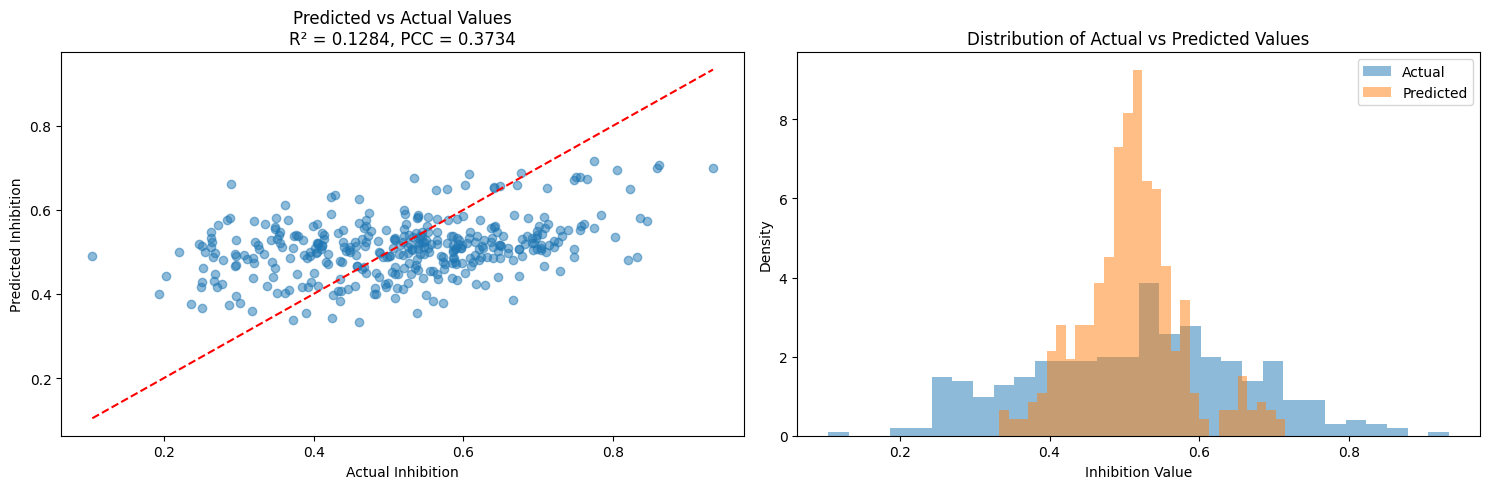

In [47]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import torch
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your trained model
checkpoint = torch.load('best_model_dnabert2.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

# Test set evaluation
model.eval()
test_loss = 0
test_predictions = []
test_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing'):
        sirna_inputs = {k: v.to(device) for k, v in batch['sirna_inputs'].items()}
        mrna_inputs = {k: v.to(device) for k, v in batch['mrna_inputs'].items()}
        numerical_features = batch['numerical_features'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(sirna_inputs, mrna_inputs, numerical_features)
        test_loss += loss_fn(outputs.squeeze(), labels).item()
        
        test_predictions.extend(outputs.squeeze().cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate metrics
avg_test_loss = test_loss / len(test_loader)
test_r2 = r2_score(test_labels, test_predictions)
test_pcc, _ = pearsonr(test_labels, test_predictions)

# Print results
print(f'\nTest Results:')
print(f'Average test loss: {avg_test_loss:.4f}')
print(f'Test R² score: {test_r2:.4f}')
print(f'Test PCC score: {test_pcc:.4f}')

# Create visualization plots
plt.figure(figsize=(15, 5))

# Scatter plot of predicted vs actual values
plt.subplot(1, 2, 1)
plt.scatter(test_labels, test_predictions, alpha=0.5)
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], 'r--')
plt.xlabel('Actual Inhibition')
plt.ylabel('Predicted Inhibition')
plt.title(f'Predicted vs Actual Values\nR² = {test_r2:.4f}, PCC = {test_pcc:.4f}')

# Distribution plot
plt.subplot(1, 2, 2)
plt.hist(test_labels, bins=30, alpha=0.5, label='Actual', density=True)
plt.hist(test_predictions, bins=30, alpha=0.5, label='Predicted', density=True)
plt.xlabel('Inhibition Value')
plt.ylabel('Density')
plt.title('Distribution of Actual vs Predicted Values')
plt.legend()
plt.tight_layout()
plt.savefig('test_results_plot.png')
plt.show()